<a href="https://colab.research.google.com/github/axpinkerton/Retail_example_notebooks/blob/main/neural_DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
## Making sure I have all the necessary packages / dependencies, pip installing if not and then importing
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import torch
import pytorch_forecasting
import pytorch_lightning as pl
from torch_lr_finder import LRFinder
import torch.nn as nn

from pytorch_lightning.callbacks import (EarlyStopping,LearningRateMonitor)
from pytorch_lightning.loggers import TensorBoardLogger
from torch_lr_finder.lr_finder import LRFinder
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE 
from pytorch_forecasting.metrics import DistributionLoss, QuantileLoss, NormalDistributionLoss
from pytorch_forecasting.data import (TorchNormalizer,GroupNormalizer)



pd.set_option('display.max_columns',500)

In [10]:
## This is just a way to import kaggle data directly without downloading it locally--the next several cells are
! pip install -q kaggle

In [11]:
# This too
from google.colab import files

In [25]:
# Un-comment this out to upload your personal kaggle details -- i removed my personal credentials for this upload to GitHub
# files.upload()

In [17]:
# Part of kaggle data fetching
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
# Part of kaggle data fetching, copying my credentials into to machine
! cp kaggle.json ~/.kaggle/

In [19]:
# Changing permisisons
! chmod 600 ~/.kaggle/kaggle.json

In [20]:
##  The actual dataset to download
! kaggle datasets download bulentsiyah/for-simple-exercises-time-series-forecasting

  0% 0.00/1.84M [00:00<?, ?B/s]
100% 1.84M/1.84M [00:00<00:00, 102MB/s]


In [21]:
##  Unzip the downloaded data
! unzip for-simple-exercises-time-series-forecasting.zip

Archive:  for-simple-exercises-time-series-forecasting.zip
  inflating: Alcohol_Sales.csv       
  inflating: BeerWineLiquor.csv      
  inflating: Deep Learning for Time Series Forecasting.png  
  inflating: Miles_Traveled.csv      
  inflating: energydata_complete.csv  
  inflating: prophet_facebook2.png   


In [22]:
# Now specify the csv to import
alcohol = pd.read_csv('Alcohol_Sales.csv')

In [23]:
# Start to clean
alcohol.columns = ['ds','y']
alcohol['ds'] = pd.to_datetime(alcohol['ds'])

In [24]:
## Fixing input data to properly load it and convert to tensors and TimeSeriesDataset

alcohol["elapsed_months"] = alcohol['ds'].dt.year * 12 + alcohol['ds'].dt.month
alcohol["elapsed_months"] -= alcohol["elapsed_months"].min()
alcohol["month"] = alcohol['ds'].dt.month.astype(str).astype("category")
len(alcohol['ds'])
alcohol['static'] = 2
alcohol['ds'] = pd.to_datetime(alcohol['ds'])
alcohol['y'] = alcohol['y'].astype(float)
alcohol['elapsed_months'] = alcohol['elapsed_months'].astype(int)
alcohol['month'] = alcohol['month'].astype('category')
alcohol['static'] = alcohol['static'].astype(int)
print(alcohol.dtypes)
alcohol

ds                datetime64[ns]
y                        float64
elapsed_months             int64
month                   category
static                     int64
dtype: object


,ds,y,elapsed_months,month,static
0,1992-01-01,3459.0,0,1,2
1,1992-02-01,3458.0,1,2,2
2,1992-03-01,4002.0,2,3,2
3,1992-04-01,4564.0,3,4,2
4,1992-05-01,4221.0,4,5,2
...,...,...,...,...,...
320,2018-09-01,12396.0,320,9,2
321,2018-10-01,13914.0,321,10,2
322,2018-11-01,14174.0,322,11,2
323,2018-12-01,15504.0,323,12,2


In [26]:
###############################################################################
max_encoder_length = 96 # Can play with this input to see how it affects the end SMAPE
max_prediction_length = 24

training_cutoff = alcohol["elapsed_months"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    alcohol[lambda x: x.elapsed_months <= training_cutoff],
    time_idx="elapsed_months",
    target="y",
    categorical_encoders={"static": NaNLabelEncoder().fit(alcohol.static)},
    group_ids=['static'],
    time_varying_unknown_reals=["y"],
    target_normalizer=GroupNormalizer(groups=["static"]),
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,

)

validation = TimeSeriesDataSet.from_dataset(training, alcohol, stop_randomization = True, predict=True, min_prediction_idx=training_cutoff + 1)
batch_size = 1  # On my local machine I'd use a larger batch size, but here Colab wanted a very low batch size
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, batch_sampler="synchronized")
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2, batch_sampler="synchronized")

In [27]:
# calculate baseline absolute error (in other words the last 'actual' value for the next 24, comparing that to the actuals)
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)
## Baseline SMAPE of .3336

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The propert

tensor(0.3336)

In [28]:
# Setting seed, creating a trainer for the learning rate finder in the next cell
pl.seed_everything(0)
trainer = pl.Trainer(gpus=0, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training
    , learning_rate=3e-2
    , hidden_size=24
    , rnn_layers=2
    , loss=NormalDistributionLoss(),
    log_interval=10,
    log_val_interval=3,
)

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (NormalDistributionLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_47702584-71d5-4d8a-9d3f-c35ed3b3f052.ckpt


suggested learning rate: 0.316227766016838


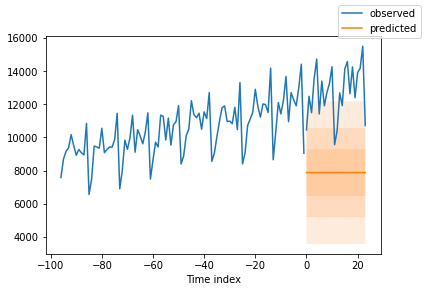

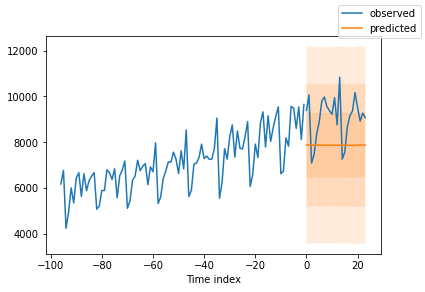

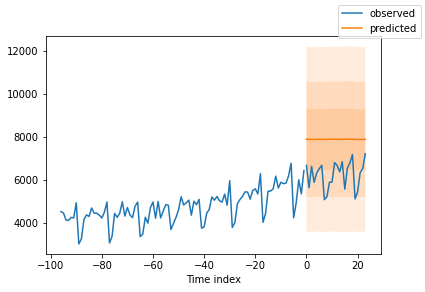

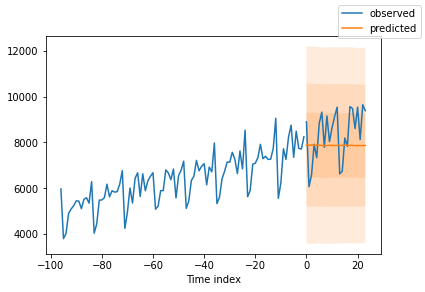

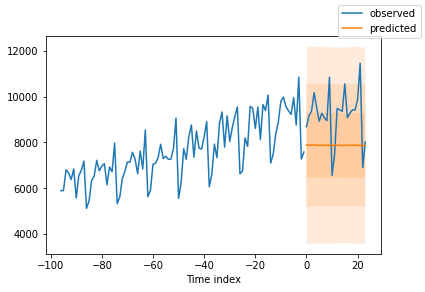

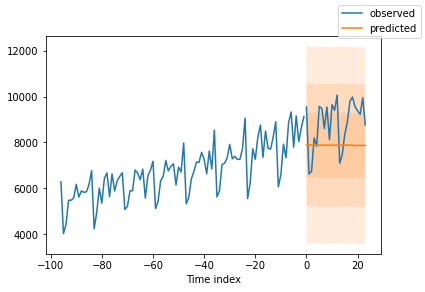

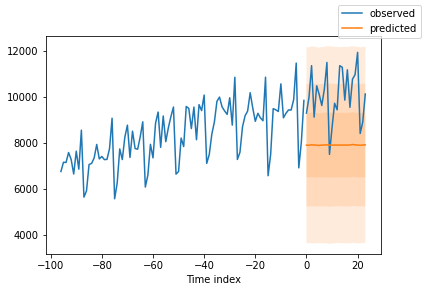

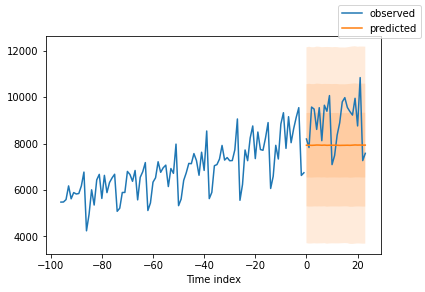

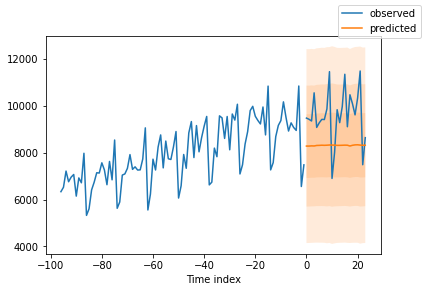

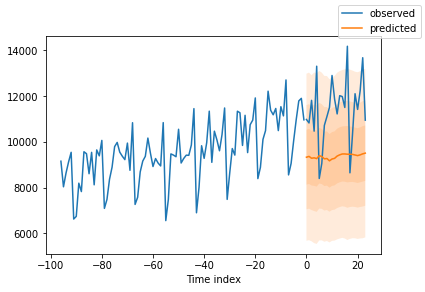

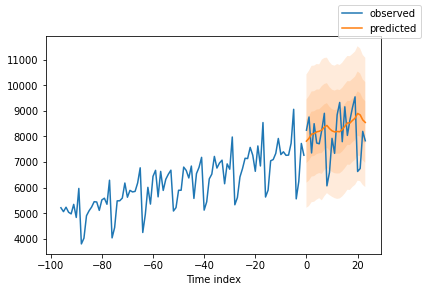

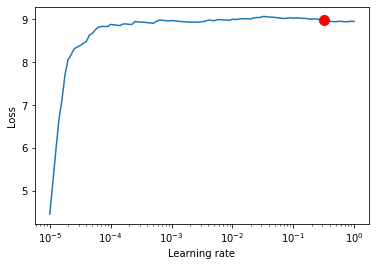

In [29]:
# find optimal learning rate for our 'baseline' trainer, will use that LR for our 'real' model
res = trainer.tuner.lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [30]:
# Setting up all of our 'real' model functions, fitting them
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=75,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=res.suggestion(),
    log_interval=10,
    log_val_interval=3,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss()
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (NormalDistributionLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/u

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [31]:
# Calling back the best model from all our epochs
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [32]:
# Looking at our predictions vs. actuals
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()
SMAPE()(baseline_predictions, actuals)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


tensor(0.3336)

In [36]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True, n_samples=100)
raw_predictions

Output(prediction=tensor([[[12415.0781, 11880.3555, 13942.7793,  ..., 13713.8779,
          13274.4502, 14443.8477],
         [13894.5957, 11635.4951, 14833.3906,  ..., 13856.7002,
           9314.6416, 10788.6387],
         [14546.4434, 11970.8223, 13402.4619,  ..., 12514.3066,
          13414.6670, 10759.6484],
         ...,
         [12066.4365, 11422.2109, 12211.7100,  ..., 17560.6641,
          16662.2734, 11367.8271],
         [12560.1406, 13159.2764, 13032.9883,  ..., 13455.8945,
           9917.5488,  8864.4346],
         [10053.9902, 12791.7178, 12537.9248,  ..., 13869.2832,
          13231.6973, 12206.2197]]]))

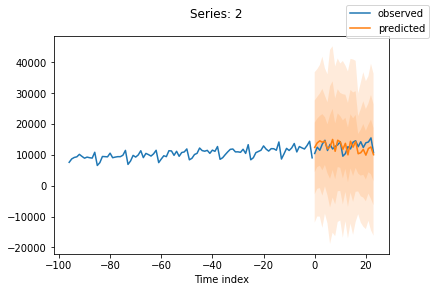

In [37]:
# Looking at the visualization
series = validation.x_to_index(x)["static"]
for idx in range(1):
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")